In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/Users/juliaarroyo/Documents/MachineLearning/football.csv')

In [4]:
df

,Team,Wins_2016,Wins_2017
0,1,3,5
1,2,3,4
2,3,2,8
3,4,2,3
4,5,6,2
5,6,6,4
6,7,7,3
7,8,7,4
8,9,8,5
9,10,7,6


In [6]:
#from nltk.cluster import KMeansClusterer, euclidean_distance, taxicab_distance

In [106]:
import math
import random
import time
import numpy as np
import pandas as pd
from tkinter import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn import datasets
######################################################################
# This section contains functions for loading CSV (comma separated values)
# files and convert them to a dataset of instances.
# Each instance is a tuple of attributes. The entire dataset is a list
# of tuples.
######################################################################
# Loads a CSV files into a list of tuples.
# Ignores the first row of the file (header).
# Numeric attributes are converted to floats, nominal attributes
# are represented with strings.
# Parameters:
#   fileName: name of the CSV file to be read
# Returns: a list of tuples
def loadCSV(fileName):
    fileHandler = open(fileName, "r")
    lines = fileHandler.readlines()
    fileHandler.close()
    del lines[0] # remove the header
    dataset = []
    for line in lines:
        instance = lineToTuple(line)
        dataset.append(instance)
    return dataset
# Converts a comma separated string into a tuple
# Parameters
#   line: a string
# Returns: a tuple
def lineToTuple(line):
    # remove leading/trailing witespace and newlines
    cleanLine = line.strip()
    # get rid of quotes
    cleanLine = cleanLine.replace('"', '')
    # separate the fields
    lineList = cleanLine.split(",")
    # convert strings into numbers
    stringsToNumbers(lineList)
    lineTuple = tuple(lineList)
    return lineTuple
# Destructively converts all the string elements representing numbers
# to floating point numbers.
# Parameters:
#   myList: a list of strings
# Returns None
def stringsToNumbers(myList):
    for i in range(len(myList)):
        if (isValidNumberString(myList[i])):
            myList[i] = float(myList[i])
# Checks if a given string can be safely converted into a positive float.
# Parameters:
#   s: the string to be checked
# Returns: True if the string represents a positive float, False otherwise
def isValidNumberString(s):
  if len(s) == 0:
    return False
  if  len(s) > 1 and s[0] == "-":
      s = s[1:]
  for c in s:
    if c not in "0123456789.":
      return False
  return True
######################################################################
# This section contains functions for clustering a dataset
# using the k-means algorithm.
######################################################################
#Jarcard distance
def jacDistance(instance1, instance2):
    if instance1 == None or instance2 == None:
        return float("inf")
    set1 = set(instance1)
    set2 = set(instance2)
    return 1 - float(len(set1.intersection(set2)) / len(set1.union(set2)))
#cosine distance
def cosDistance(instance1, instance2):
    if instance1 == None or instance2 == None:
        return float("inf")
    newInstance1 = np.array(instance1).reshape(1, -1)
    newInstance2 = np.array(instance2).reshape(1, -1)
    return 1 - cosine_similarity(newInstance1, newInstance2)
#manhattan
def manDistance(instance1, instance2):
    if instance1 == None or instance2 == None:
        return float("inf")
    sum = 0
    for i in range(1, len(instance1)):
        sum += abs(instance1[i] - instance2[i])
    return sum
#Euclidean
def euDistance(instance1, instance2):
    if instance1 == None or instance2 == None:
        return float("inf")
    sumOfSquares = 0
    for i in range(1, len(instance1)):
        sumOfSquares += (instance1[i] - instance2[i])**2
    return math.sqrt(sumOfSquares)
def distance(instance1, instance2, similarity):
    if similarity == 'Euclidean':
        return euDistance(instance1, instance2)
    elif similarity == "Cosine":
        return cosDistance(instance1, instance2)
    elif similarity == "Manhattan":
        return manDistance(instance1, instance2)
    elif similarity == "Jaccard":
        return jacDistance(instance1, instance2)
    else:
        print("ERROR")
        return
def meanInstance(name, instanceList):
    numInstances = len(instanceList)
    if (numInstances == 0):
        return
    numAttributes = len(instanceList[0])
    means = [name] + [0] * (numAttributes-1)
    for instance in instanceList:
        for i in range(1, numAttributes):
            means[i] += instance[i]
    for i in range(1, numAttributes):
        means[i] /= float(numInstances)
    return tuple(means)
def assign(instance, centroids, similarity):
    minDistance = distance(instance, centroids[0], similarity)
    minDistanceIndex = 0
    for i in range(1, len(centroids)):
        d = distance(instance, centroids[i], similarity)
        if (d < minDistance):
            minDistance = d
            minDistanceIndex = i
    return minDistanceIndex
def createEmptyListOfLists(numSubLists):
    myList = []
    for i in range(numSubLists):
        myList.append([])
    return myList
def assignAll(instances, centroids, similarity):
    clusters = createEmptyListOfLists(len(centroids))
    for instance in instances:
        clusterIndex = assign(instance, centroids, similarity)
        clusters[clusterIndex].append(instance)
    return clusters
def computeCentroids(clusters):
    centroids = []
    for i in range(len(clusters)):
        # name = "centroid" + str(i)
        name = i
        centroid = meanInstance(name, clusters[i])
        centroids.append(centroid)
    return centroids
def kmeans(instances, k, animation=False, initCentroids=None, similarity='Euclidean'):
    result = {}
    if (initCentroids == None or len(initCentroids) < k):
        # randomly select k initial centroids
        random.seed(time.time())
        centroids = random.sample(instances, k)
        # print(centroids)
    else:
        centroids = initCentroids
    prevCentroids = []
    if animation:
        delay = 1.0 # seconds
        canvas = prepareWindow(instances)
        clusters = createEmptyListOfLists(k)
        clusters[0] = instances
        paintClusters2D(canvas, clusters, centroids, "Initial centroids")
        time.sleep(delay)
    iteration = 0
    while (centroids != prevCentroids):
        iteration += 1
        clusters = assignAll(instances, centroids, similarity)
        if animation:
            paintClusters2D(canvas, clusters, centroids, "Assign %d" % iteration)
            time.sleep(delay)
        prevCentroids = centroids
        centroids = computeCentroids(clusters)
        withinss = computeWithinss(clusters, centroids, similarity)
        if animation:
            paintClusters2D(canvas, clusters, centroids,
                            "Update %d, withinss %.1f" % (iteration, withinss))
            time.sleep(delay)
    result["clusters"] = clusters
    result["centroids"] = centroids
    result["withinss"] = withinss
    result["sse"]=withinss
    return result
def computeWithinss(clusters, centroids, similarity):
    result = 0
    for i in range(len(centroids)):
        centroid = centroids[i]
        cluster = clusters[i]
        for instance in cluster:
            result += distance(centroid, instance, similarity) ** 2
    return result
# Repeats k-means clustering n times, and returns the clustering
# with the smallest withinss
def repeatedKMeans(instances, k, n):
    bestClustering = {}
    bestClustering["withinss"] = float("inf")
    for i in range(1, n+1):
        print ("k-means trial %d," % i , trialClustering = kmeans(instances, k))
        print ("withinss: %.1f" % trialClustering["withinss"])
        if trialClustering["withinss"] < bestClustering["withinss"]:
            bestClustering = trialClustering
            minWithinssTrial = i
    print ("Trial with minimum withinss:", minWithinssTrial)
    return bestClustering

######################################################################
# This section contains functions for visualizing datasets and
# clustered datasets.
######################################################################
def printTable(instances):
    for instance in instances:
        if instance != None:
            line = str(instance[0]) + "\t"
            for i in range(1, len(instance)):
                line += "%.2f " % instance[i]
            print (line)
def extractAttribute(instances, index):
    result = []
    for instance in instances:
        result.append(instance[index])
    return result
def paintCircle(canvas, xc, yc, r, color):
    canvas.create_oval(xc-r, yc-r, xc+r, yc+r, outline=color)
def paintSquare(canvas, xc, yc, r, color):
    canvas.create_rectangle(xc-r, yc-r, xc+r, yc+r, fill=color)
def drawPoints(canvas, instances, color, shape):
    random.seed(0)
    width = canvas.winfo_reqwidth()
    height = canvas.winfo_reqheight()
    margin = canvas.data["margin"]
    minX = canvas.data["minX"]
    minY = canvas.data["minY"]
    maxX = canvas.data["maxX"]
    maxY = canvas.data["maxY"]
    scaleX = float(width - 2*margin) / (maxX - minX)
    scaleY = float(height - 2*margin) / (maxY - minY)
    for instance in instances:
        x = 5*(random.random()-0.5)+margin+(instance[1]-minX)*scaleX
        y = 5*(random.random()-0.5)+height-margin-(instance[2]-minY)*scaleY
        if (shape == "square"):
            paintSquare(canvas, x, y, 5, color)
        else:
            paintCircle(canvas, x, y, 5, color)
    canvas.update()
def connectPoints(canvas, instances1, instances2, color):
    width = canvas.winfo_reqwidth()
    height = canvas.winfo_reqheight()
    margin = canvas.data["margin"]
    minX = canvas.data["minX"]
    minY = canvas.data["minY"]
    maxX = canvas.data["maxX"]
    maxY = canvas.data["maxY"]
    scaleX = float(width - 2*margin) / (maxX - minX)
    scaleY = float(height - 2*margin) / (maxY - minY)
    for p1 in instances1:
        for p2 in instances2:
            x1 = margin + (p1[1]-minX)*scaleX
            y1 = height - margin - (p1[2]-minY)*scaleY
            x2 = margin + (p2[1]-minX)*scaleX
            y2 = height - margin - (p2[2]-minY)*scaleY
            canvas.create_line(x1, y1, x2, y2, fill=color)
    canvas.update()
def mergeClusters(clusters):
    result = []
    for cluster in clusters:
        result.extend(cluster)
    return result
def prepareWindow(instances):
    width = 500
    height = 500
    margin = 50
    root = Tk()
    canvas = Canvas(root, width=width, height=height, background="white")
    canvas.pack()
    canvas.data = {}
    canvas.data["margin"] = margin
    setBounds2D(canvas, instances)
    paintAxes(canvas)
    canvas.update()
    return canvas
def setBounds2D(canvas, instances):
    attributeX = extractAttribute(instances, 1)
    attributeY = extractAttribute(instances, 2)
    canvas.data["minX"] = min(attributeX)
    canvas.data["minY"] = min(attributeY)
    canvas.data["maxX"] = max(attributeX)
    canvas.data["maxY"] = max(attributeY)
def paintAxes(canvas):
    width = canvas.winfo_reqwidth()
    height = canvas.winfo_reqheight()
    margin = canvas.data["margin"]
    minX = canvas.data["minX"]
    minY = canvas.data["minY"]
    maxX = canvas.data["maxX"]
    maxY = canvas.data["maxY"]
    canvas.create_line(margin/2, height-margin/2, width-5, height-margin/2,
                       width=2, arrow=LAST)
    canvas.create_text(margin, height-margin/4,
                       text=str(minX), font="Sans 11")
    canvas.create_text(width-margin, height-margin/4,
                       text=str(maxX), font="Sans 11")
    canvas.create_line(margin/2, height-margin/2, margin/2, 5,
                       width=2, arrow=LAST)
    canvas.create_text(margin/4, height-margin,
                       text=str(minY), font="Sans 11", anchor=W)
    canvas.create_text(margin/4, margin,
                       text=str(maxY), font="Sans 11", anchor=W)
    canvas.update()
def showDataset2D(instances):
    canvas = prepareWindow(instances)
    paintDataset2D(canvas, instances)
def paintDataset2D(canvas, instances):
    canvas.delete(ALL)
    paintAxes(canvas)
    drawPoints(canvas, instances, "blue", "circle")
    canvas.update()
def showClusters2D(clusteringDictionary):
    clusters = clusteringDictionary["clusters"]
    centroids = clusteringDictionary["centroids"]
    withinss = clusteringDictionary["withinss"]
    canvas = prepareWindow(mergeClusters(clusters))
    paintClusters2D(canvas, clusters, centroids,
                    "Withinss: %.1f" % withinss)
def paintClusters2D(canvas, clusters, centroids, title=""):
    canvas.delete(ALL)
    paintAxes(canvas)
    colors = ["blue", "red", "green", "brown", "purple", "orange"]
    for clusterIndex in range(len(clusters)):
        color = colors[clusterIndex%len(colors)]
        instances = clusters[clusterIndex]
        centroid = centroids[clusterIndex]
        drawPoints(canvas, instances, color, "circle")
        if (centroid != None):
            drawPoints(canvas, [centroid], color, "square")
        connectPoints(canvas, [centroid], instances, color)
    width = canvas.winfo_reqwidth()
    canvas.create_text(width/2, 20, text=title, font="Sans 14")
    canvas.update()
######################################################################
# Test code
######################################################################
iris = datasets.load_iris()
#data = pd.DataFrame(preprocessing.normalize(iris.data), columns = iris.feature_names)
#need to normalize all columns except target so we can figure out what it is at the end
#data = pd.DataFrame(iris.data, columns = iris.feature_names)
#data = preprocessing.normalize(data.iloc[:,:-1])
#data['target'] = pd.Series(iris.target)
#cols = list(data)
#cols.insert(0, cols.pop(cols.index('target')))
#data = data.loc[:, cols]
#dataset = data.values.tolist()


#dataset = loadCSV('/Users/juliaarroyo/Documents/MachineLearning/iris.csv')
#data = preprocessing.normalize(dataset.iloc[:,:-1])
#****************FOOTBALL DATA***********************************
#dataset = loadCSV('/Users/juliaarroyo/Documents/MachineLearning/football.csv')
#centroids = [[0,4,6],[0,5,4]]
#*********************IRIS DATA NORMALIZED**************************
dataset = loadCSV('/Users/juliaarroyo/Documents/MachineLearning/iris2.csv')
#********************************************************
#dataset = pd.DataFrame(data=dataset)
#dataset=dataset.iloc[:,[1,2,3,4]]

#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(dataset)
#dataset = pd.DataFrame(x_scaled)

#dataset = pd.concat([dataset[0],dataset],axis = 1)
#dataset = dataset.values.tolist()


showDataset2D(dataset)
#******************CLUSTERING FOR FOOTBALL DATA***********************
#clustering = kmeans(dataset, 2, True, centroids, similarity='Euclidean')
#******************CLUSTERING FOR IRIS DATA***************************
#clustering = kmeans(dataset, 3, False, None, similarity='Euclidean')


iris = datasets.load_iris()
data = pd.DataFrame(preprocessing.normalize(iris.data), columns = iris.feature_names)
data.insert(0,'Target', iris.target)
irisDataSet = data.values.tolist()

distArray = ["Euclidean", "Jaccard", "Cosine"]

for i in distArray:
    irisClustering = kmeans(irisDataSet, 3, False, similarity = i)
    #print(i, "Iris Data, Random init centroids", printTable(irisClustering["centroids"]))
    clusters = (irisClustering['clusters'])
    #print(clusters)
    sse = computeWithinss(irisClustering["clusters"], irisClustering["centroids"], similarity = i)
    #print("Sum of SE",i,sse)

#printTable(clustering["centroids"])
#print(len(clustering["clusters"][0]))
#print(len(clustering["clusters"][1]))
#print(len(clustering["clusters"][2]))
def printT(i):
    print("\nSum of Squared Error is: "+str(i))
printT(clustering["sse"])

irisClustering = kmeans(irisDataSet, 3, False, similarity = 'Jaccard')
print('Euclidean', "Iris Data, Random init centroids", printTable(irisClustering["centroids"]))
clusters = (irisClustering['clusters'])
print(clusters)
sse = computeWithinss(irisClustering["clusters"], irisClustering["centroids"], similarity = i)
print("Sum of SE",i,sse)




Sum of Squared Error is: 6.9822164751457825
0	0.80 0.55 0.23 0.04 
1	0.75 0.35 0.54 0.17 
2	0.70 0.32 0.59 0.22 
Euclidean Iris Data, Random init centroids None
[[[0.0, 0.8037727730153805, 0.5516087657948691, 0.2206435063179476, 0.03152050090256395], [0.0, 0.8281328733868766, 0.5070201265633938, 0.23660939239625042, 0.033801341770892925], [0.0, 0.8053330753805038, 0.5483118811101303, 0.22275170170099043, 0.03426949256938314], [0.0, 0.8000302474620595, 0.5391508189418228, 0.2608794285202368, 0.03478392380269824], [0.0, 0.7909649964604158, 0.5694947974514994, 0.22147019900891643, 0.03163859985841664], [0.0, 0.7841749862818121, 0.5663486012035309, 0.2468699030887186, 0.05808703602087497], [0.0, 0.7801093556963545, 0.5766025672538273, 0.23742458651628182, 0.050876697110631815], [0.0, 0.8021849185198159, 0.5454857445934748, 0.24065547555594477, 0.03208739674079264], [0.0, 0.8064236561517831, 0.5315065006454933, 0.2565893451392037, 0.03665562073417196], [0.0, 0.8180311900353677, 0.517529936

In [107]:
from sklearn.metrics import accuracy_score as acc
clusters[0] = pd.DataFrame(clusters[0])
mode = clusters[0].iloc[:,0].mode()
print('*************', mode)
clusters[0]['Mode'] = 0
acc1 = acc(clusters[0]['Mode'],clusters[0][0])
print('##########', acc1)
#clusters[0] = clusters[0].assign(Mode = mode)
print(clusters[0])
clusters[1] = pd.DataFrame(clusters[1])
mode = clusters[1].iloc[:,0].mode()
print('*************', mode)
clusters[1]['Mode'] = 1
acc2 = acc(clusters[1]['Mode'],clusters[1][0])
print('##########', acc2)
print(clusters[1])
clusters[2] = pd.DataFrame(clusters[2])
mode = clusters[2].iloc[:,0].mode()
print('*************', mode)
clusters[2]['Mode'] = 2
clusters[2] = pd.DataFrame(clusters[2])
acc3 = acc(clusters[2]['Mode'],clusters[2][0])
print('##########', acc3)
print(clusters[2])


************* 0    0.0
dtype: float64
########## 1.0
      0         1         2         3         4  Mode
0   0.0  0.803773  0.551609  0.220644  0.031521     0
1   0.0  0.828133  0.507020  0.236609  0.033801     0
2   0.0  0.805333  0.548312  0.222752  0.034269     0
3   0.0  0.800030  0.539151  0.260879  0.034784     0
4   0.0  0.790965  0.569495  0.221470  0.031639     0
5   0.0  0.784175  0.566349  0.246870  0.058087     0
6   0.0  0.780109  0.576603  0.237425  0.050877     0
7   0.0  0.802185  0.545486  0.240655  0.032087     0
8   0.0  0.806424  0.531507  0.256589  0.036656     0
9   0.0  0.818031  0.517530  0.250418  0.016695     0
10  0.0  0.803735  0.550707  0.223260  0.029768     0
11  0.0  0.786991  0.557452  0.262330  0.032791     0
12  0.0  0.823072  0.514420  0.240063  0.017147     0
13  0.0  0.802513  0.559893  0.205294  0.018663     0
14  0.0  0.811209  0.559454  0.167836  0.027973     0
15  0.0  0.773811  0.597328  0.203635  0.054303     0
16  0.0  0.794289  0.573653  

In [91]:
dataset = loadCSV('/Users/juliaarroyo/Documents/MachineLearning/iris.csv')
dataset = pd.DataFrame(data=dataset)
df1=dataset.iloc[:,[1,2,3,4]]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df1)
df = pd.DataFrame(x_scaled)
df
df2 = pd.concat([dataset[0],df1],axis = 1)

#normalized_df=(df1-df1.mean())/df1.std()
#normalized_df
#data = preprocessing.normalize(dataset.iloc[:,:-1])

[(0.0, 5.1, 3.5, 1.4, 0.2), (0.0, 4.9, 3.0, 1.4, 0.2), (0.0, 4.7, 3.2, 1.3, 0.2), (0.0, 4.6, 3.1, 1.5, 0.2), (0.0, 5.0, 3.6, 1.4, 0.2), (0.0, 5.4, 3.9, 1.7, 0.4), (0.0, 4.6, 3.4, 1.4, 0.3), (0.0, 5.0, 3.4, 1.5, 0.2), (0.0, 4.4, 2.9, 1.4, 0.2), (0.0, 4.9, 3.1, 1.5, 0.1), (0.0, 5.4, 3.7, 1.5, 0.2), (0.0, 4.8, 3.4, 1.6, 0.2), (0.0, 4.8, 3.0, 1.4, 0.1), (0.0, 4.3, 3.0, 1.1, 0.1), (0.0, 5.8, 4.0, 1.2, 0.2), (0.0, 5.7, 4.4, 1.5, 0.4), (0.0, 5.4, 3.9, 1.3, 0.4), (0.0, 5.1, 3.5, 1.4, 0.3), (0.0, 5.7, 3.8, 1.7, 0.3), (0.0, 5.1, 3.8, 1.5, 0.3), (0.0, 5.4, 3.4, 1.7, 0.2), (0.0, 5.1, 3.7, 1.5, 0.4), (0.0, 4.6, 3.6, 1.0, 0.2), (0.0, 5.1, 3.3, 1.7, 0.5), (0.0, 4.8, 3.4, 1.9, 0.2), (0.0, 5.0, 3.0, 1.6, 0.2), (0.0, 5.0, 3.4, 1.6, 0.4), (0.0, 5.2, 3.5, 1.5, 0.2), (0.0, 5.2, 3.4, 1.4, 0.2), (0.0, 4.7, 3.2, 1.6, 0.2), (0.0, 4.8, 3.1, 1.6, 0.2), (0.0, 5.4, 3.4, 1.5, 0.4), (0.0, 5.2, 4.1, 1.5, 0.1), (0.0, 5.5, 4.2, 1.4, 0.2), (0.0, 4.9, 3.1, 1.5, 0.2), (0.0, 5.0, 3.2, 1.2, 0.2), (0.0, 5.5, 3.5, 1.3, 0.2), 

KeyError: 0

In [4]:
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing

iris = datasets.load_iris()
data = pd.DataFrame(preprocessing.normalize(iris.data), columns = iris.feature_names)

In [13]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Load data and store it into pandas DataFrame objects
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data[:, :], columns = iris.feature_names[:])
y = pd.DataFrame(iris.target, columns =["Species"])
X = pd.concat([y,X],axis = 1)
X.to_csv(r'/Users/juliaarroyo/Documents/MachineLearning/iris.csv',index = False)


In [18]:
#3 unique species
y
#y.Species.unique()

,Species
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


/Users/juliaarroyo/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/juliaarroyo/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_


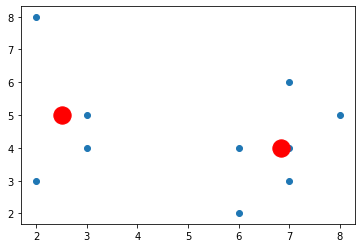

27.833333333333336

In [6]:
X = df.iloc[:, [1,2]].values

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
centroid = [[4,6],[5,4]]
arr = np.array(centroid)
kmeans = KMeans(n_clusters=2, init=arr, max_iter=300, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()
kmeans.cluster_centers_
kmeans.inertia_



In [7]:
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data[:, :], columns = iris.feature_names[:])
y = pd.DataFrame(iris.target, columns =["Species"])
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
centroid = [[4,6],[5,4]]
arr = np.array(centroid)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
pred_y = kmeans.fit_predict(X)
#plt.scatter(X[:,0], X[:,1])
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
#plt.show()
kmeans.cluster_centers_
kmeans.inertia_

78.85144142614601

In [9]:
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data[:, :], columns = iris.feature_names[:])
y = pd.DataFrame(iris.target, columns =["Species"])
X = pd.concat([y,X],axis = 1)

In [10]:
X

,Species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,2,6.7,3.0,5.2,2.3
146,2,6.3,2.5,5.0,1.9
147,2,6.5,3.0,5.2,2.0
148,2,6.2,3.4,5.4,2.3


In [13]:
import math
import random
import time
import numpy as np
import pandas as pd
from tkinter import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn import datasets
iris = datasets.load_iris()
#data = pd.DataFrame(preprocessing.normalize(iris.data), columns = iris.feature_names)

In [12]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  